In [1]:
import os, sys, math
import numpy as np
import glob
import copy
import mdtraj
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import seaborn as sns
import barnaba as bb

In [2]:
# plot settings
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.precision = 1
pd.options.display.float_format = '{:.1f}'.format

params = {'legend.fontsize': 40, 
          'font.size': 40, 
          'axes.labelsize': 48,
          'axes.titlesize': 48,
          'xtick.labelsize': 40,
          'ytick.labelsize': 40,
          'savefig.dpi': 600, 
          'figure.figsize': [64, 8],
          'xtick.major.size': 10,
          'xtick.minor.size': 7,
          'ytick.major.size': 10,
          'ytick.minor.size': 7}

plt.rcParams.update(params)

In [3]:
def radian_to_degree(a):    
    a[np.where(a<0.0)] += 2.*np.pi
    a *= 180.0/np.pi

    # same as above
    #a = a*(180./np.pi)
    #a[np.where(a<0.0)] += 360
    
    return a

In [9]:
def plot_backbone_chi(angle):
    # histogram
    angle = radian_to_degree(angle)
    plt.hist(angle, bins=60)
    plt.show()
    plt.close()
            
    # time trajectory
    plt.plot(angle)
    plt.ylim(0,360)
    plt.show()
    plt.close

In [10]:
def plot_sugar_pucker(pucker):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1,polar=True)
    ax.scatter(pucker[0], pucker[1], s=10)

    p3 = np.pi/5
    ax.text(0.5*p3, 1.6, "C3'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(1.3*p3, 1.5, "C4'-exo",  ha='center', fontsize=16)
    ax.text(2.5*p3, 1.5, "O4'-endo", ha='center', fontsize=16)
    ax.text(3.7*p3, 1.5, "C1'-exo",  ha='center', fontsize=16)
    ax.text(4.5*p3, 1.6, "C2'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(5.5*p3, 1.5, "C3'-exo",  ha='center', fontsize=16)
    ax.text(6.5*p3, 1.5, "C4'-endo", ha='center', fontsize=16)
    ax.text(7.5*p3, 1.6, "O4'-exo",  ha='center', fontsize=16)
    ax.text(8.5*p3, 1.5, "C1'-endo", ha='center', fontsize=16)
    ax.text(9.5*p3, 1.5, "C2'-exo",  ha='center', fontsize=16)

    xt = np.arange(0, 2*np.pi, p3)
    ax.set_xticks(xt)
    ax.set_yticks([])
    ax.set_ylim(0, 1.2)
    ax.tick_params(axis='both', labelsize=12)
    plt.tight_layout()

    plt.show()
    #plt.savefig("pucker.png")    
    plt.close()

In [19]:
def cluster(feat):
    from sklearn.cluster import KMeans
    from scipy.spatial.distance import euclidean

    kmeans = KMeans(n_clusters=100, random_state=0, n_init="auto").fit(feat)

    # Loop over all clusters and find index of closest point to the cluster center.
    frame_idx = []
    for idx in range(kmeans.n_clusters):
        # get all points assigned to each cluster
        cluster_feat = feat[kmeans.labels_ == idx]
        # get all indices of points assigned to this cluster
        cluster_idx = np.where(kmeans.labels_ == idx)[0]

        cluster_center = kmeans.cluster_centers_[idx]
        min_idx = np.argmin([euclidean(feat[_idx], cluster_center) for _idx in cluster_idx])

        frame_idx.append(cluster_idx[min_idx])

        #print('cluster center ', cluster_cen)
        #print('closest point to cluster center: ', cluster_feat[min_idx])
        #print('closest index of point to cluster center: ', cluster_idx[min_idx])
        #print('  ', feat[cluster_pts_indices[min_idx]])
        
    return frame_idx

In [20]:
def run(files):
    for file in files:
        name = file.split('/')[2]
        traj = mdtraj.load(f'../md/{name}/traj.nc', top=f'../md/crd/{name}.pdb')

        # backbone chi
        chi, _ = bb.backbone_angles_traj(traj, angles=['chi'])
        chi = chi.reshape(chi.shape[0], 1)
        angle = copy.deepcopy(chi)
        plot_backbone_chi(angle)

        # sugar pucker
        pucker, _ = bb.pucker_rao_traj(traj)
        pucker = pucker.reshape(pucker.shape[0], pucker.shape[2]).T
        plot_sugar_pucker(pucker)

        # cluster
        feat = np.concatenate((chi, pucker.T), axis=1)
        frame_idx = cluster(feat)

        # save
        traj[frame_idx].save_netcdf(f'traj_cls_{name}.nc')

        # check cluster sample
        angle = copy.deepcopy(chi)
        plot_backbone_chi(angle[frame_idx])
        plot_sugar_pucker(pucker[:,frame_idx])

### Cluster trajectory

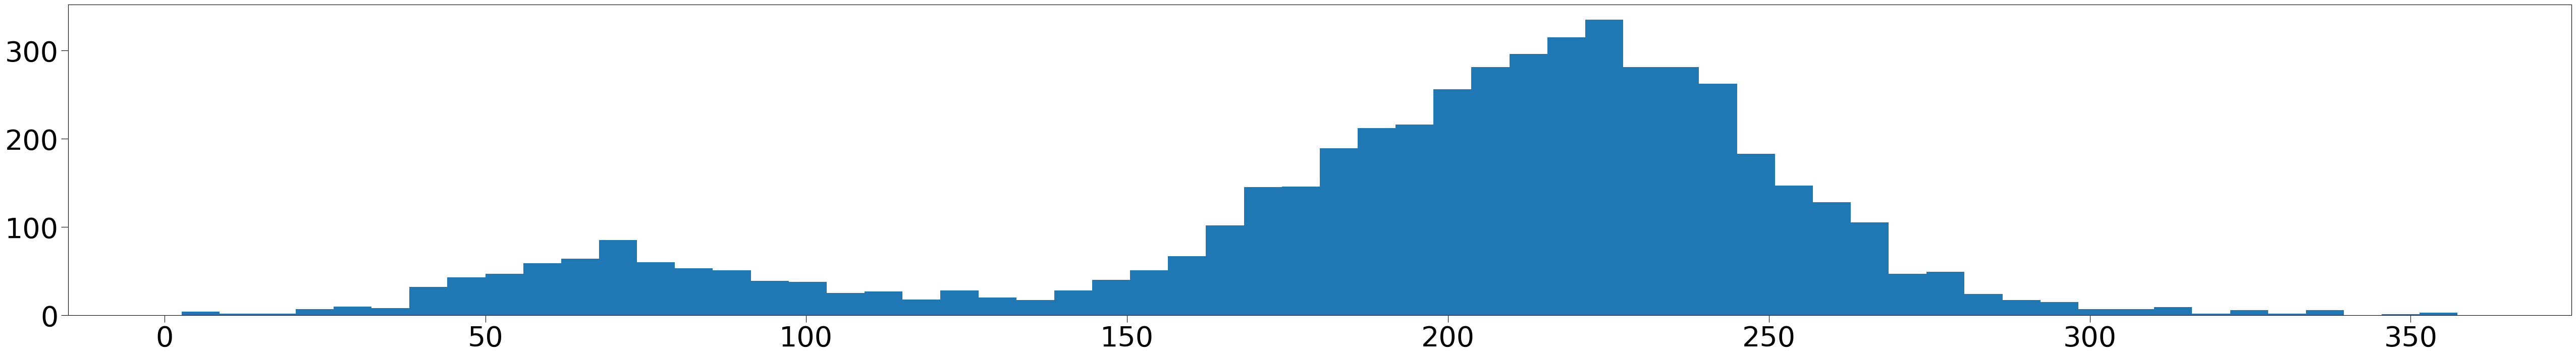

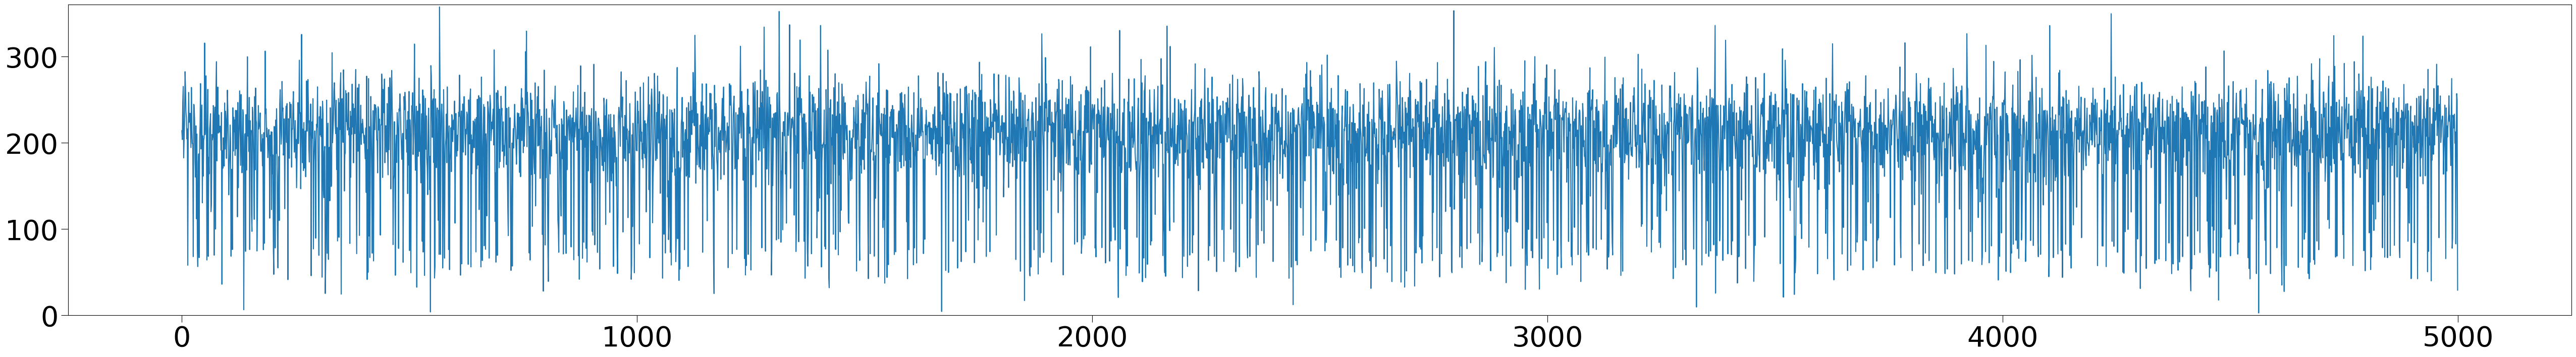

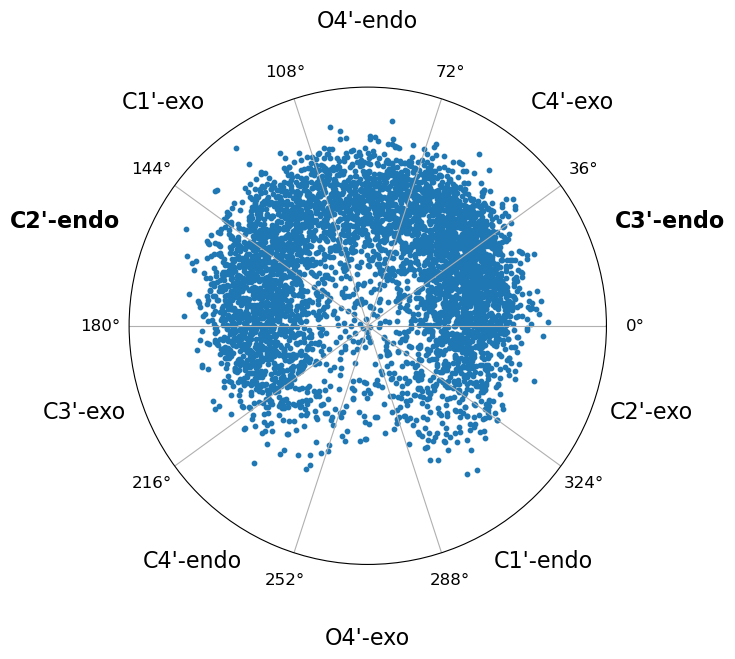

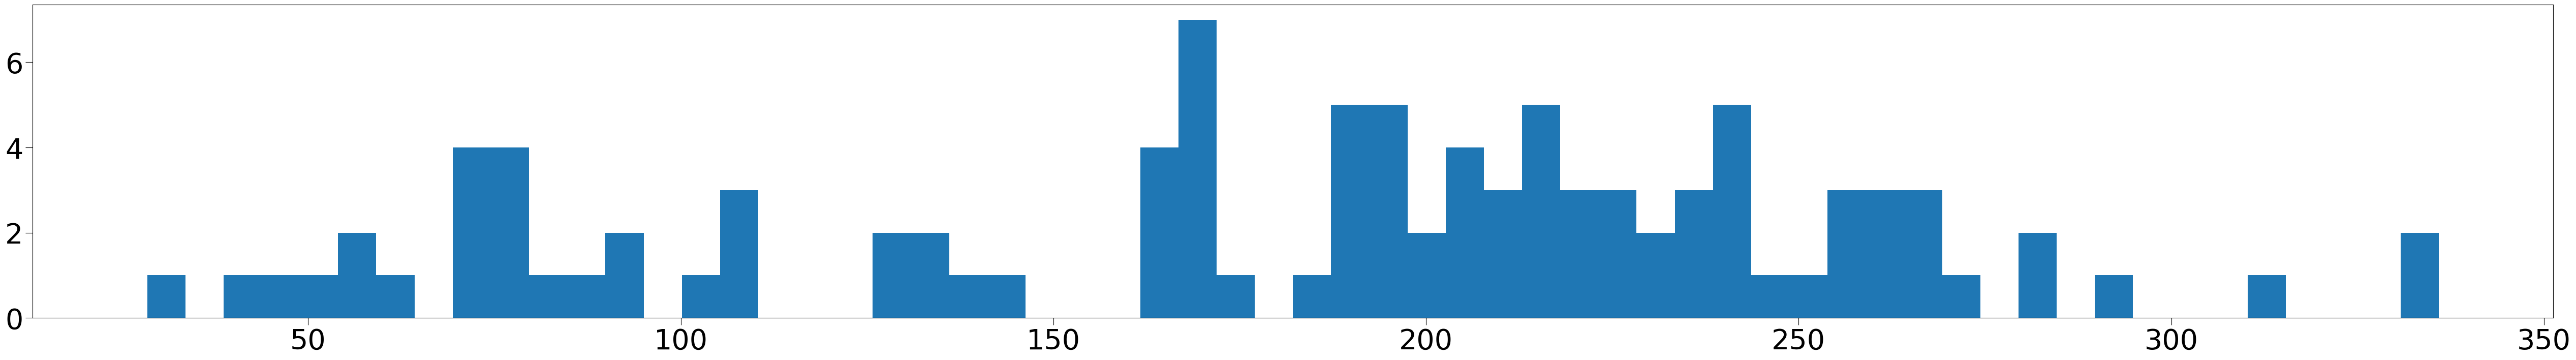

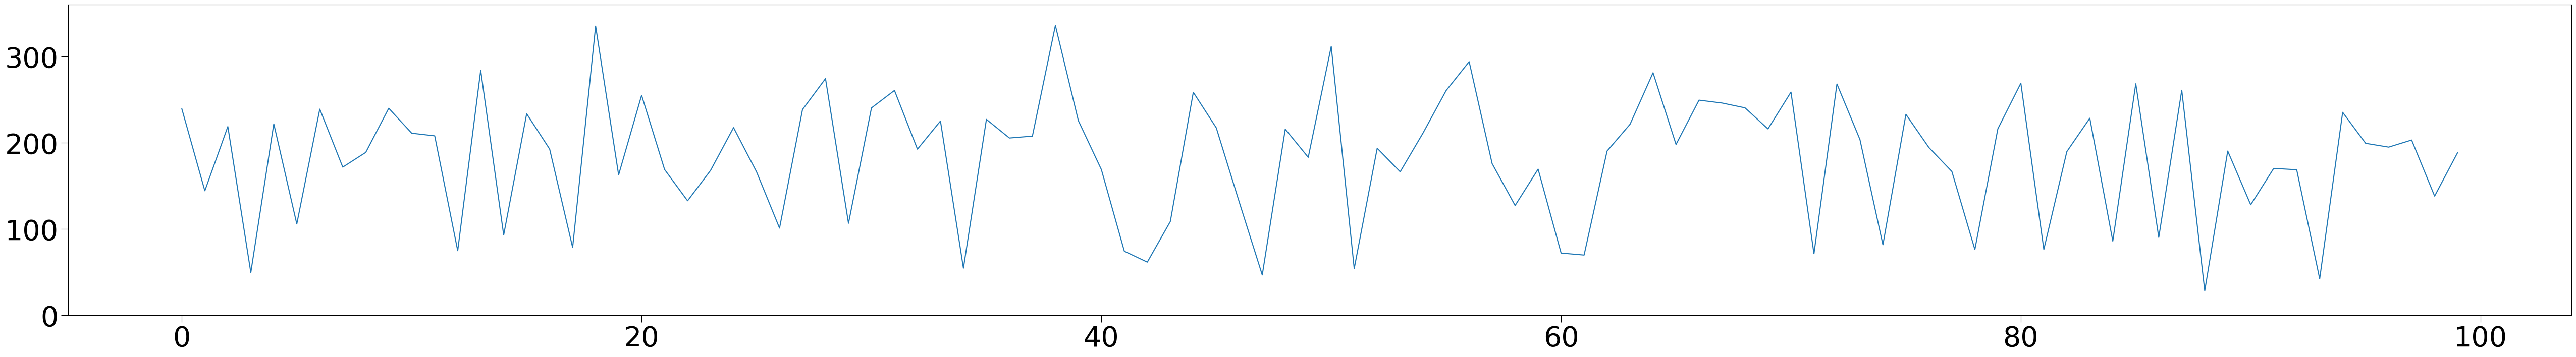

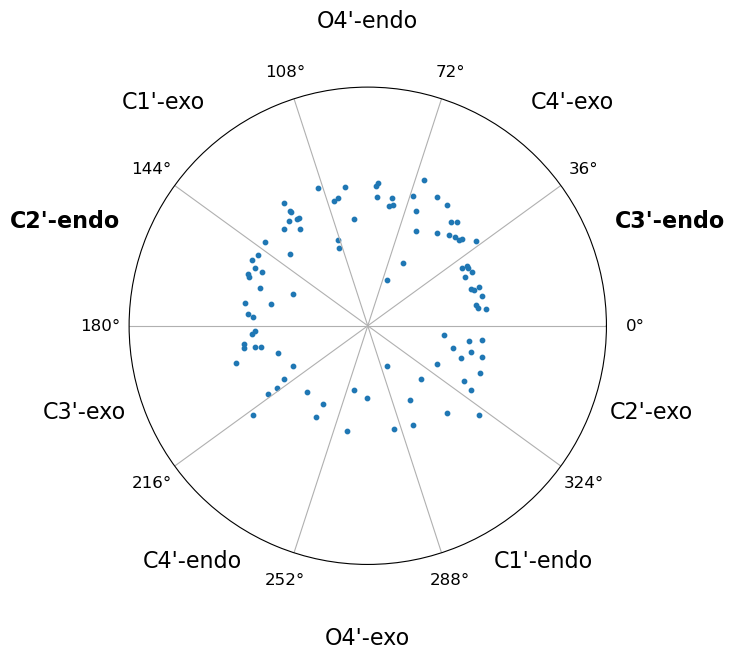

In [21]:
# adenosine
#files = glob.glob("../md/a*/traj.nc")
files = glob.glob("../md/a/traj.nc")
run(files)

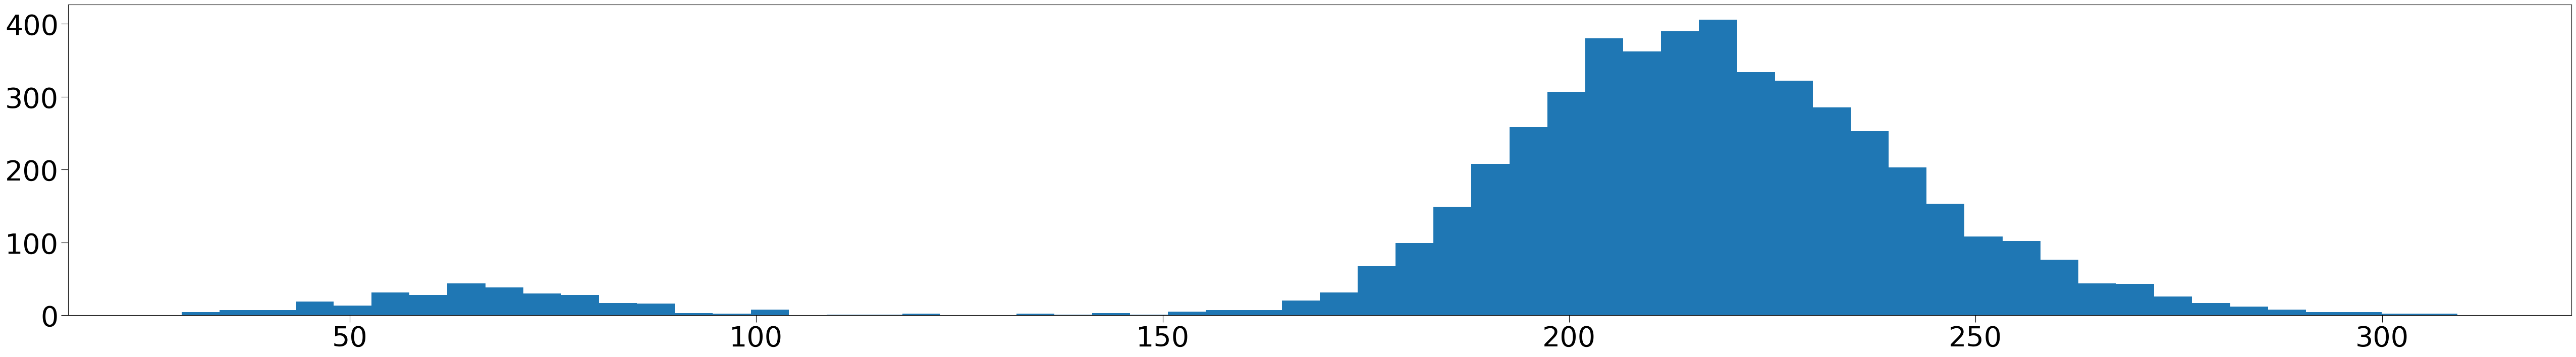

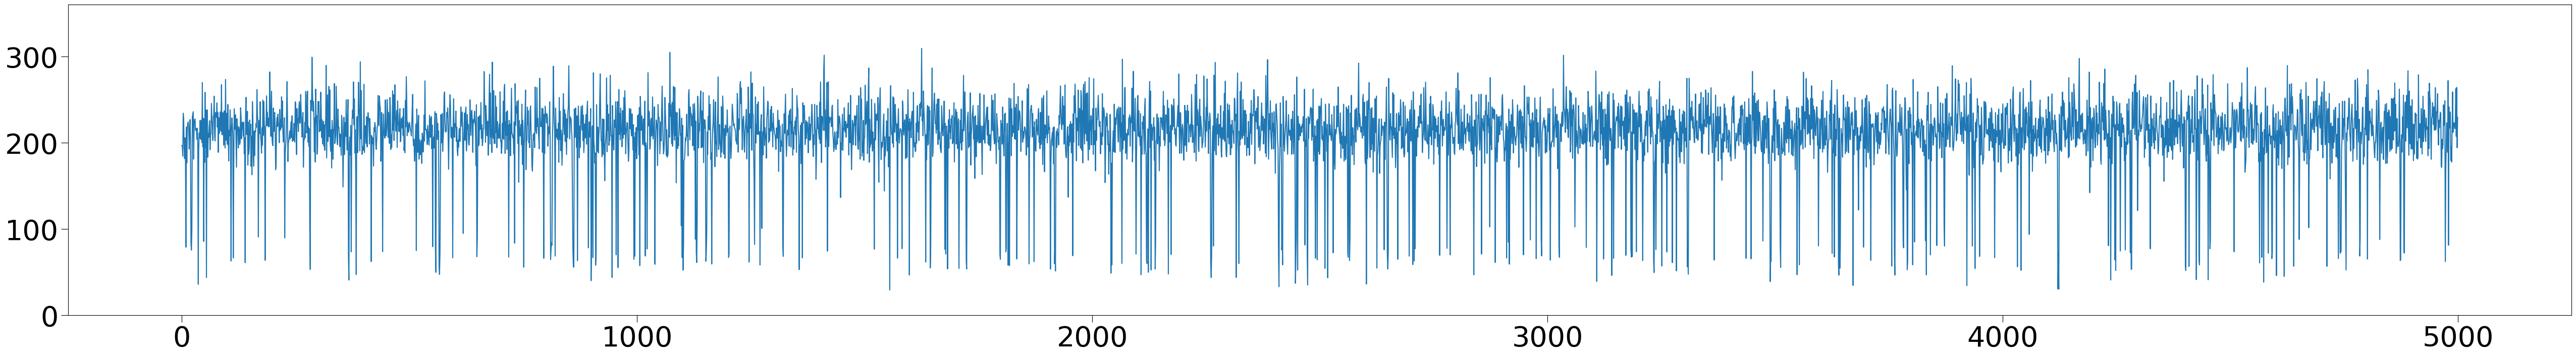

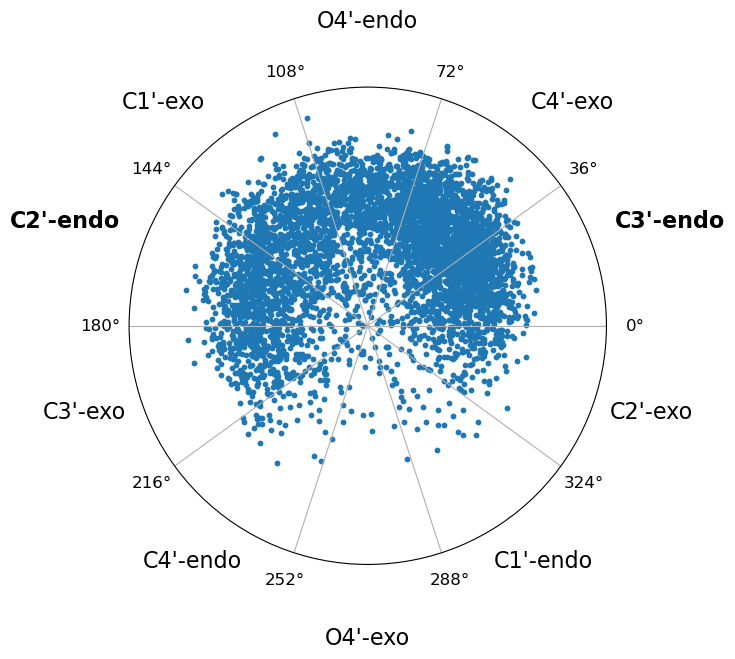

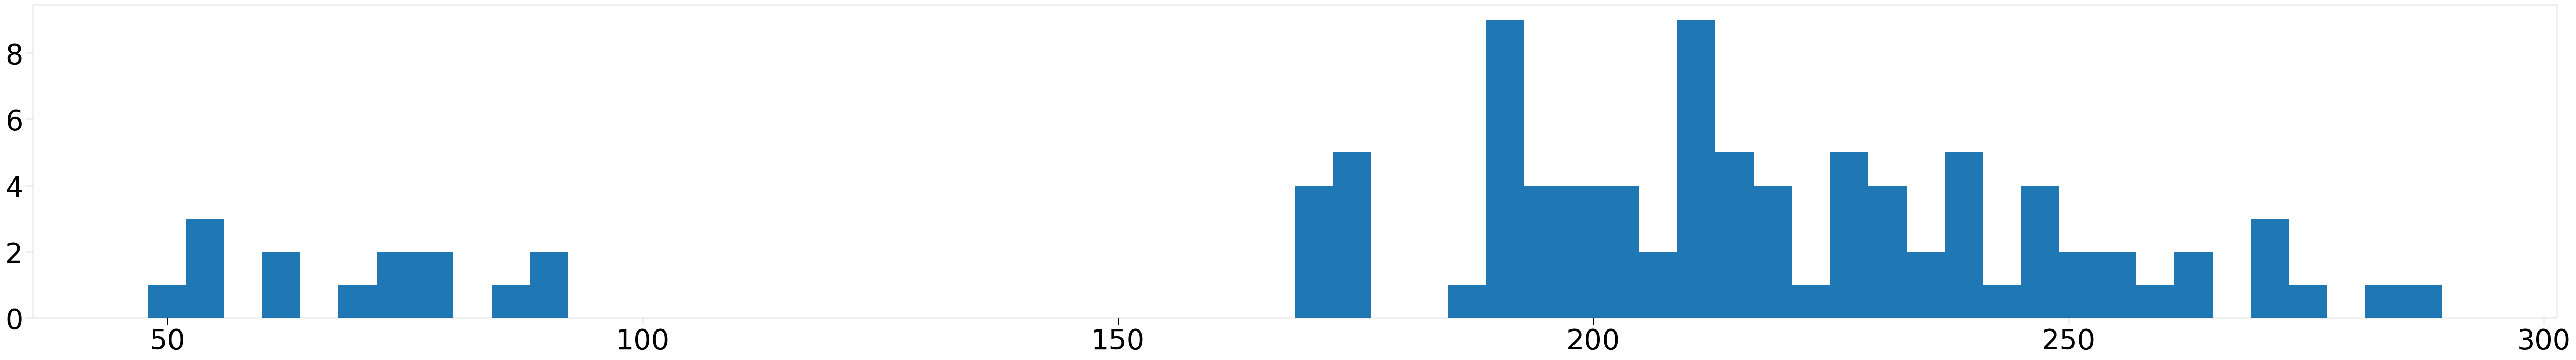

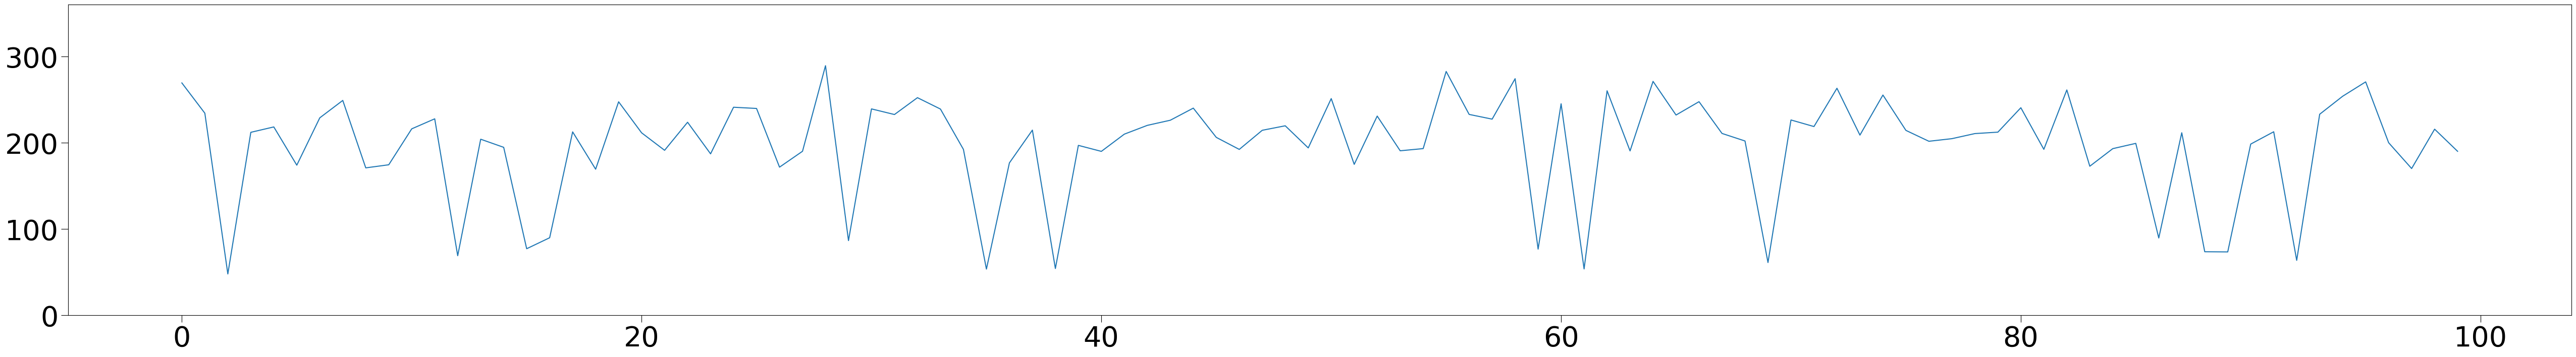

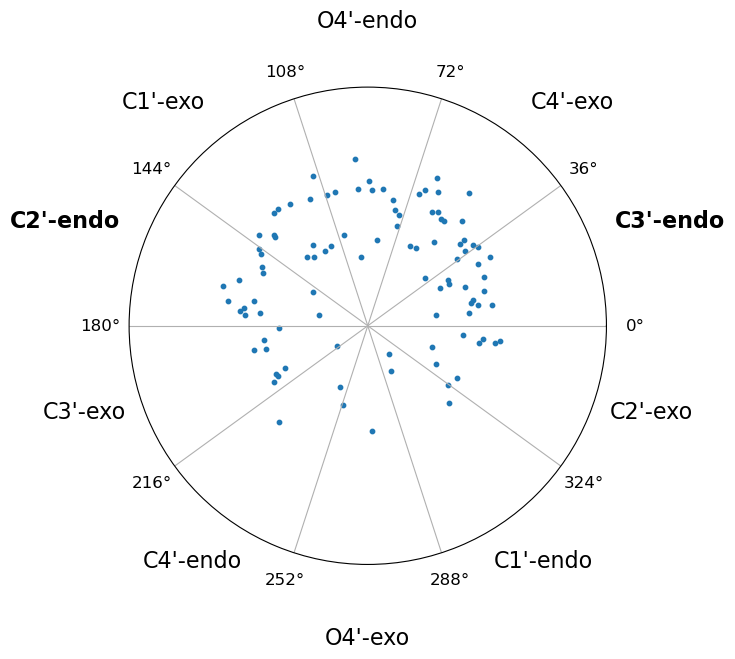

In [22]:
# cytidine
#files = glob.glob("../md/c*/traj.nc")
files = glob.glob("../md/c/traj.nc")
run(files)

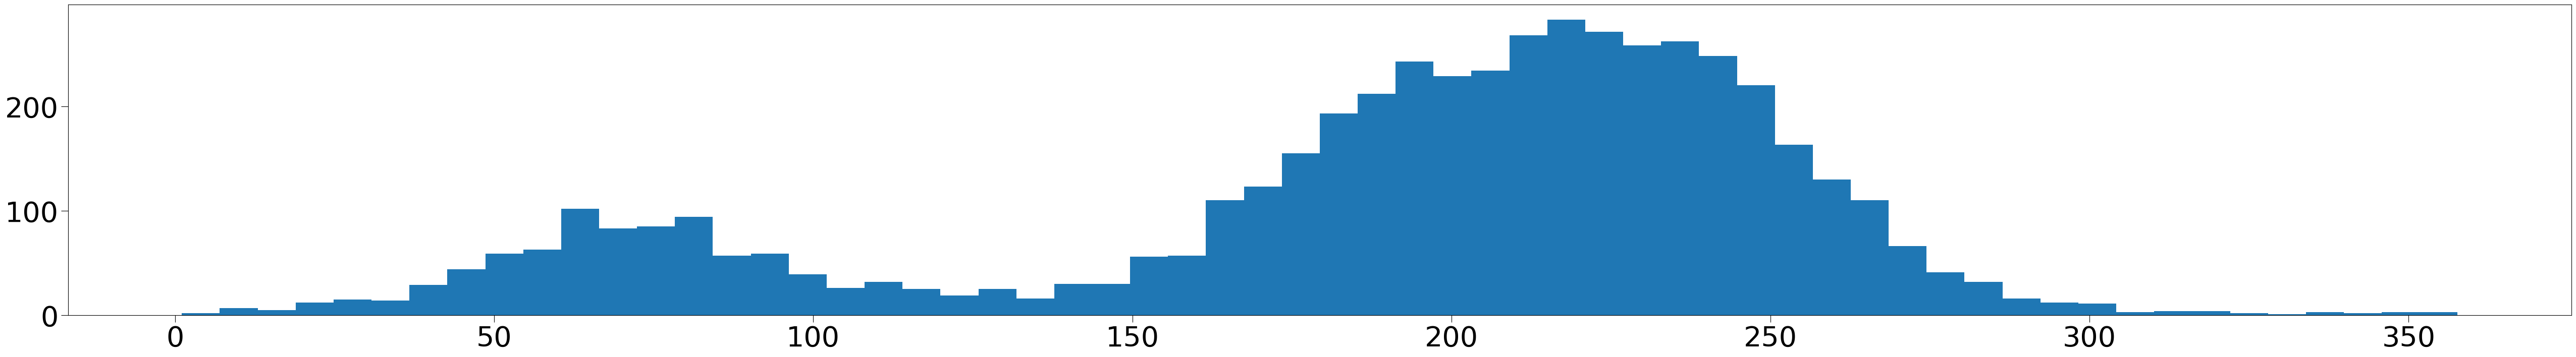

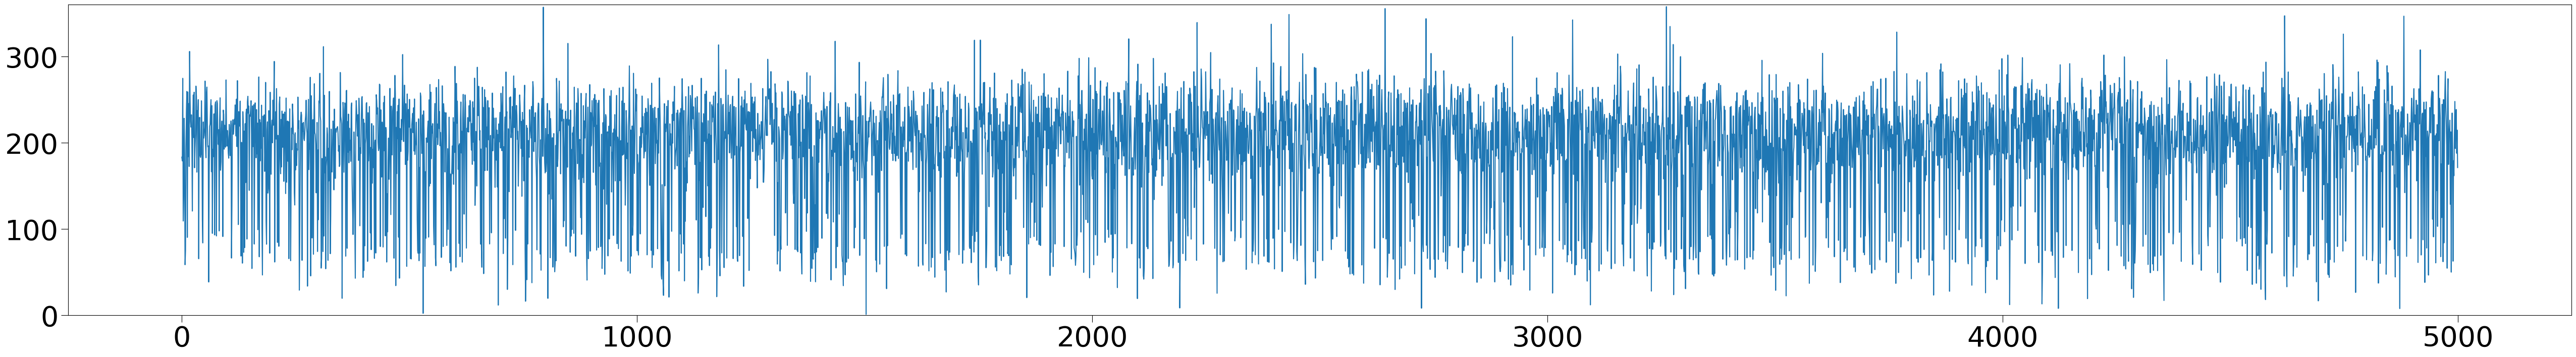

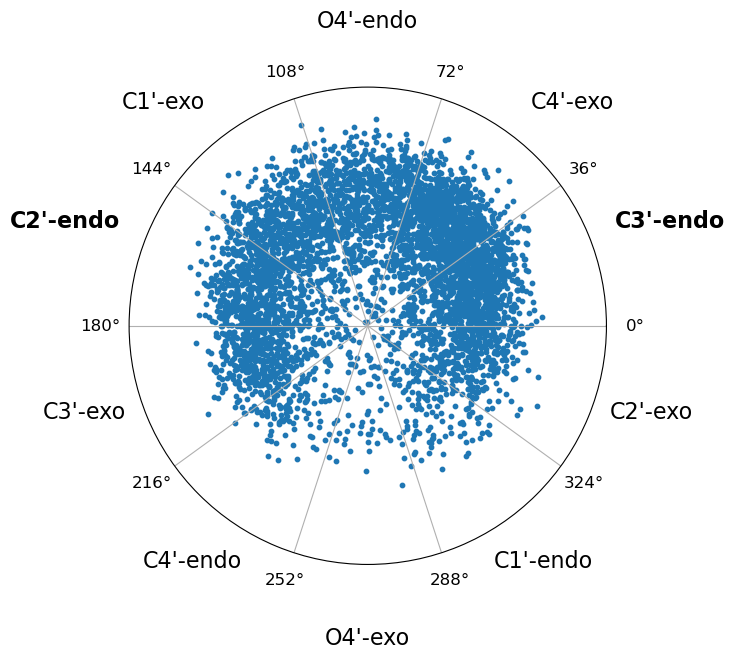

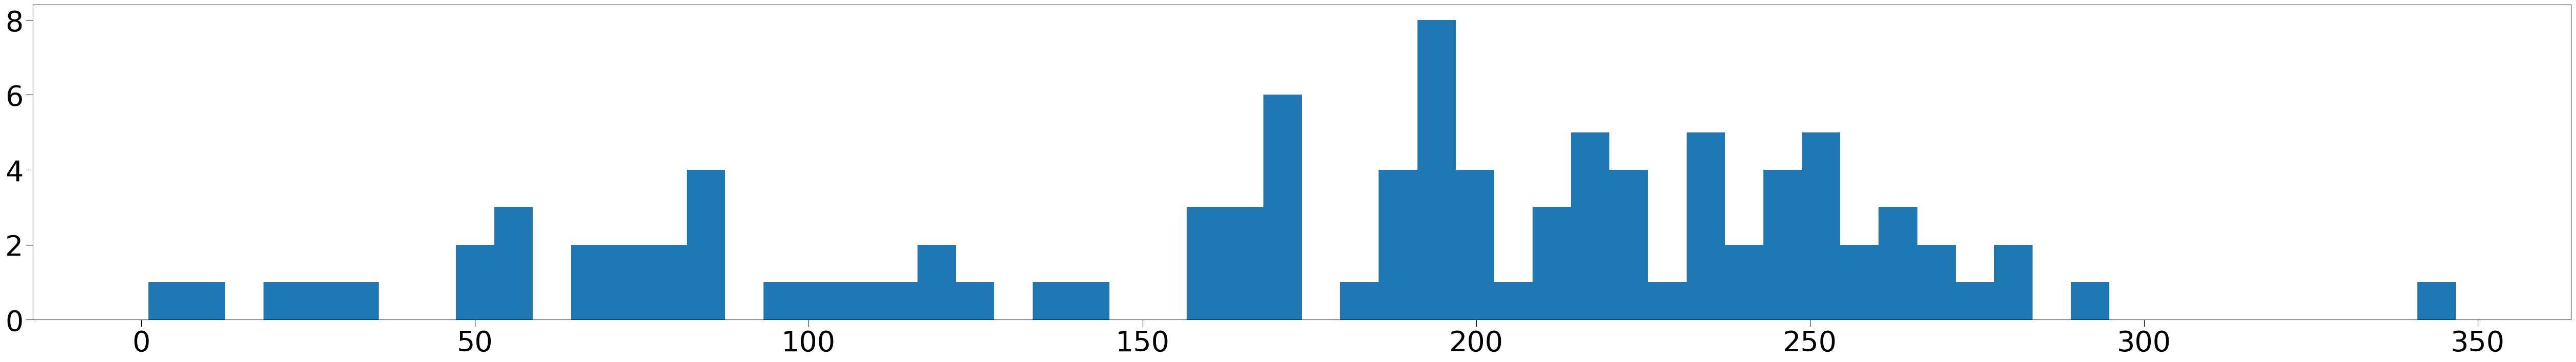

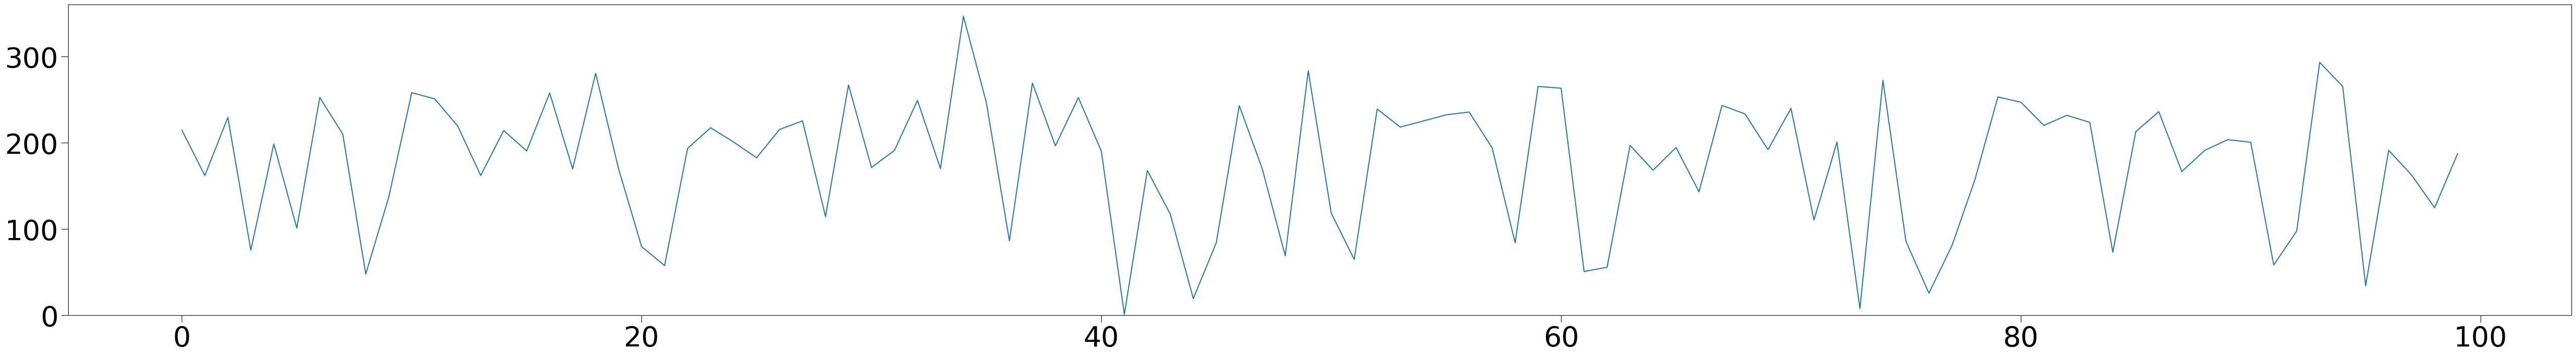

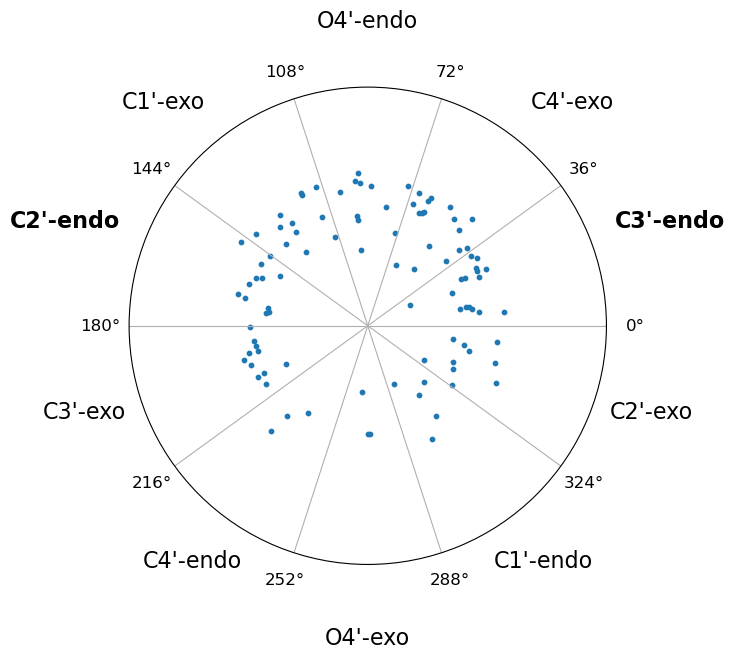

In [23]:
# guanosine
#files = glob.glob("../md/*/traj.nc")
files = glob.glob("../md/g/traj.nc")
run(files)

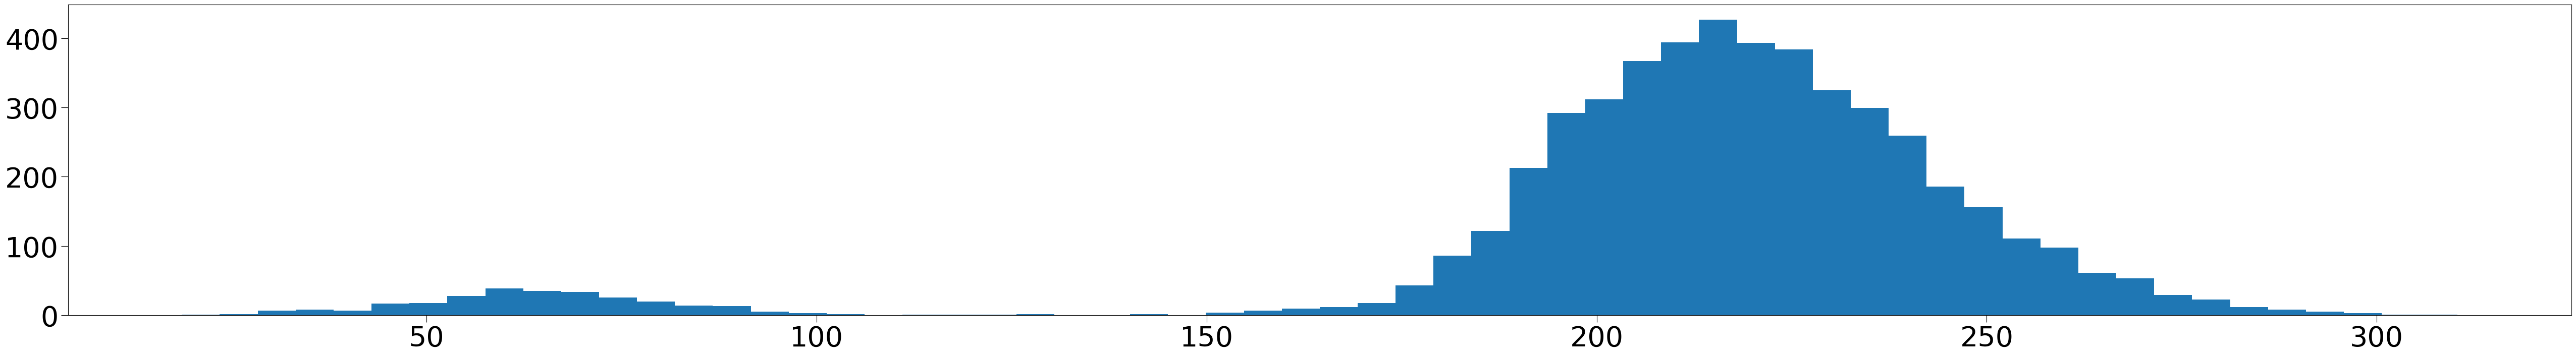

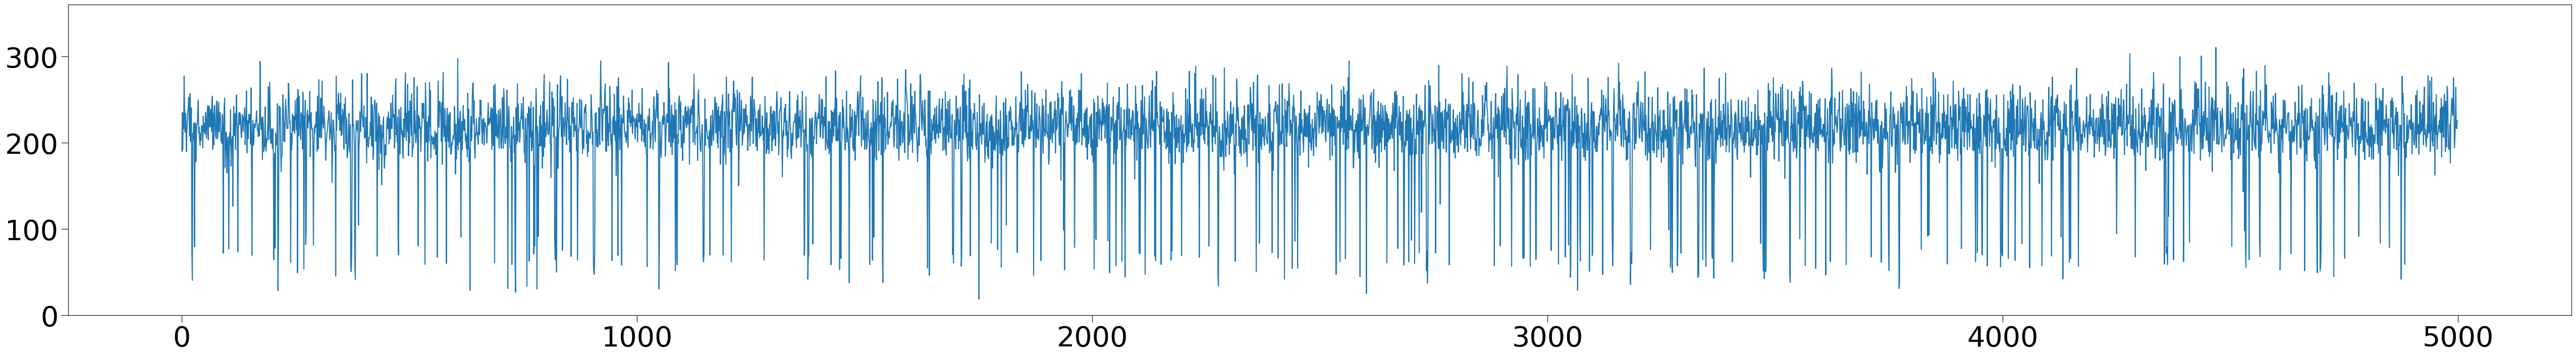

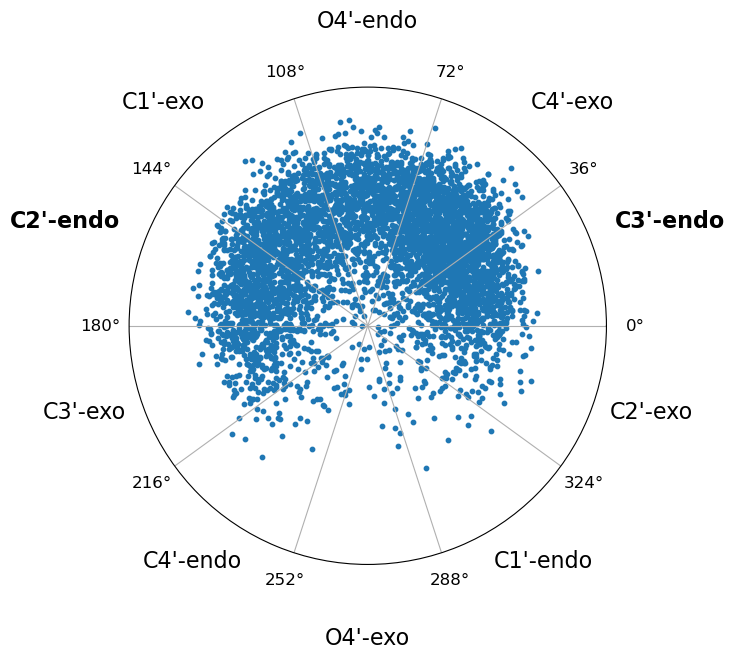

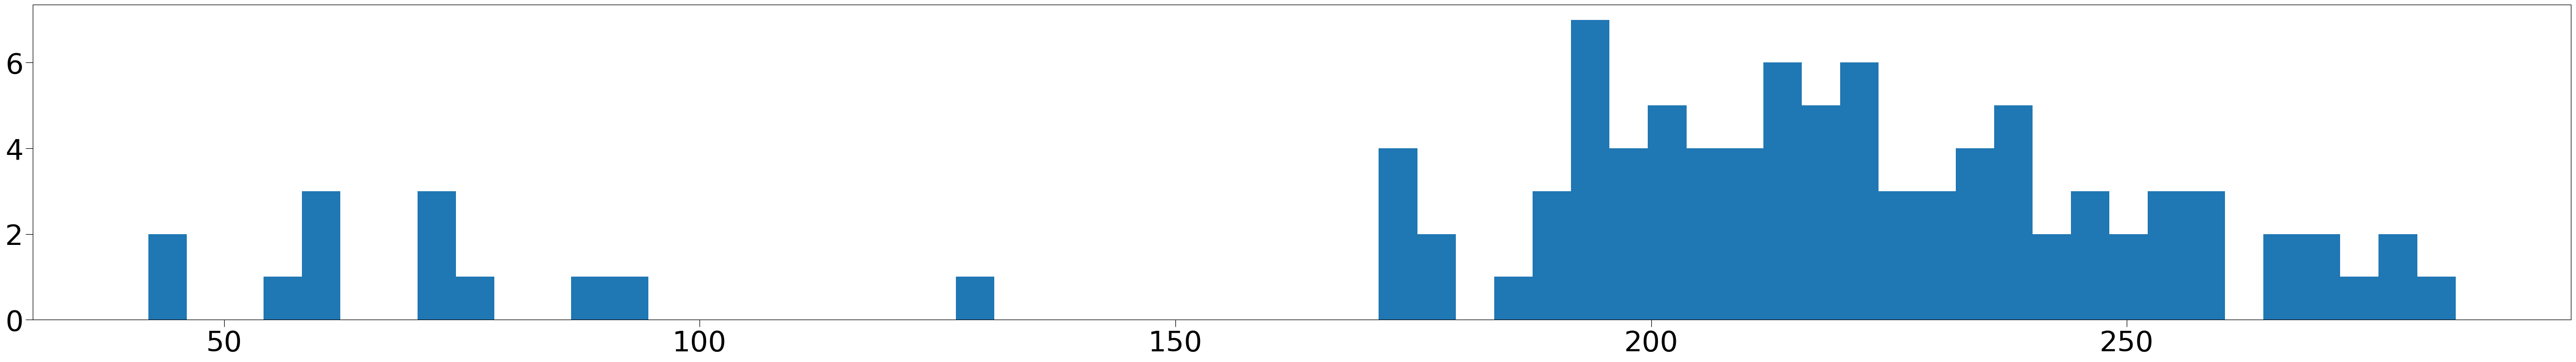

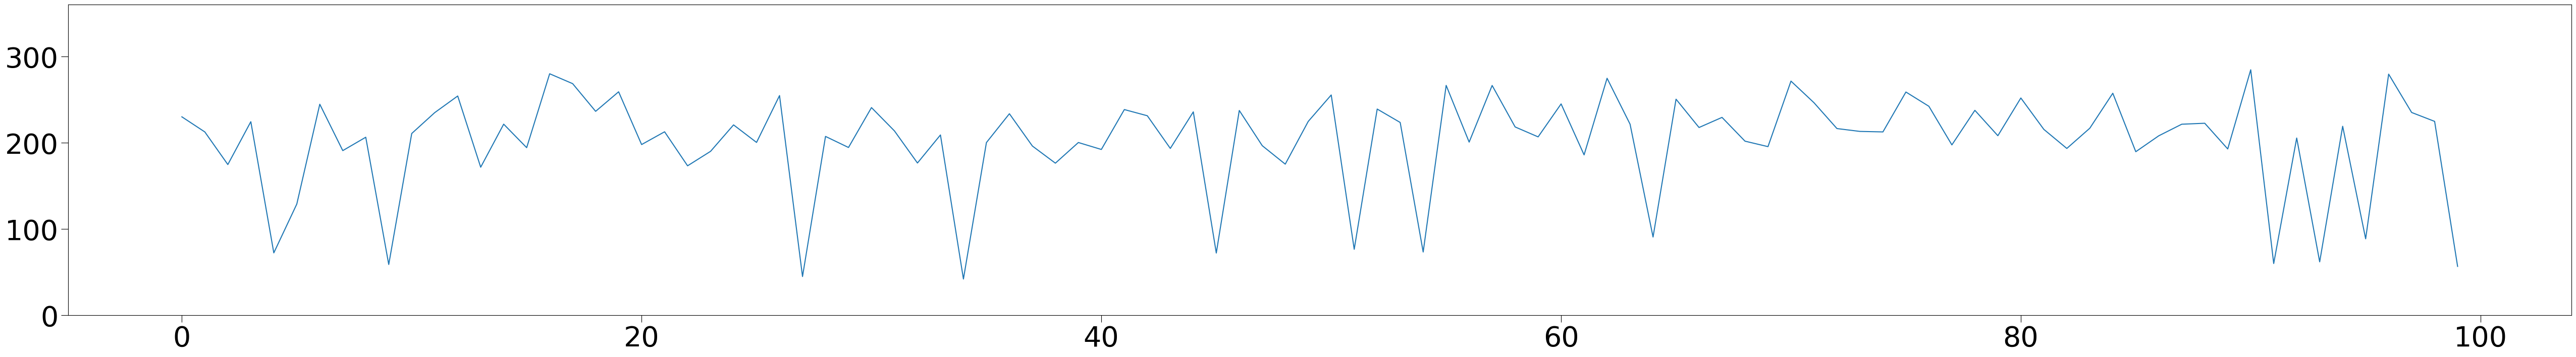

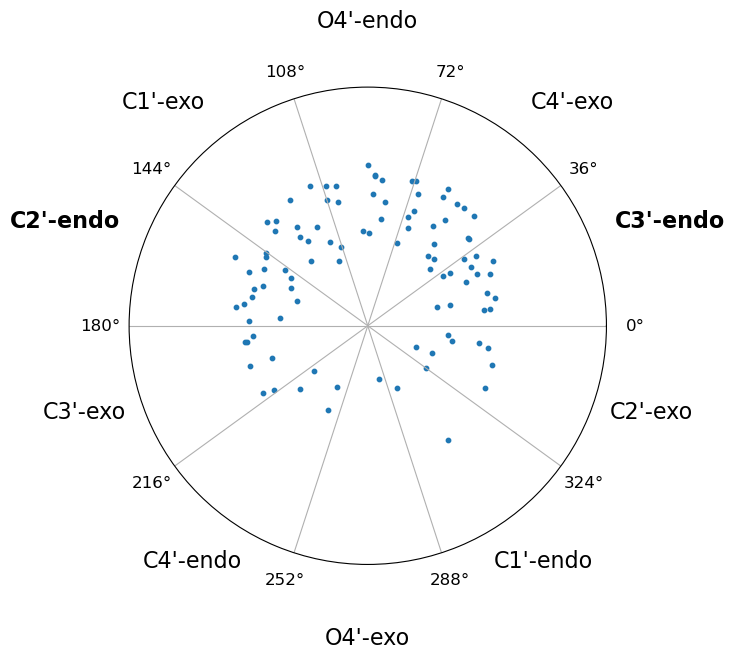

In [24]:
# uridine
#files = glob.glob("../md/u*/traj.nc")
files = glob.glob("../md/u/traj.nc")
run(files)